# A short example to compute AFIBS distributions 
- The AFIBS statistic is defined in Theunert et al 2012
- The first AFIBS implementation was made for Jay et al MBE 2019 
- The second AFIBS implementation is based on Positional Burrows-Wheeler transform (PBWT) and is an adaptation of Durbin's algorithm for computing haplotype sharing efficiently

In [1]:
import summary_statistics as ss
import matplotlib.pyplot as plt
import numpy as np
import msprime
import seaborn as sns

## Default parameters for simulation

In [2]:
simu_settings_default = {'L': 2000000,  # Size of one segment
                 'n_haplo': 18,  # number of haplotypes
                 'mu': 1.25*10**(-8),  # mutation rate (per gen)
                 'rho': 1.3*10**(-8),  # recombination rate (per gen)
                 'longtermNe': 10000.0,  # Average Long-Term Effective Pop Size
                 }

## Change some parameters if needed and launch msprime simulations
e.g. you can change the recombination rate, Ne or the number of haplotypes  
this is a simple simulation of constant populations size  

In [3]:
simu_settings = simu_settings_default
simu_settings['n_haplo'] = 22
n_rep = 10 

# simulate
ts_reps = list(msprime.simulate(
    sample_size=simu_settings['n_haplo'], 
    Ne=simu_settings['longtermNe'], 
    recombination_rate=simu_settings['rho'], 
    mutation_rate=simu_settings['mu'], 
    length=simu_settings['L'], 
    num_replicates=n_rep))

pos_list = []
hap_list = []
count_list = []
for rep, ts in enumerate(ts_reps):
    pos = np.array([variant.site.position for variant in ts.variants()])
    pos_list.append(pos.astype(int))
    hap = ts.genotype_matrix().T
    hap_list.append(hap)
count_list = [hap.sum(axis=0).astype(int) for hap in hap_list]

## Compute the two first moments of AFIBS distribution (mean and sd)

### with the original algorithm (using encoding of configurations)

In [4]:
# tends to fail for large values of n_haplo
res_afibs = ss.distrib_afibs(hap_list, pos_list, count_list, durbin_bwt=False)

### or with the the algorithm base on BWT 
see AFIBS_BWT directory and notebook for details

In [5]:
res_afibs_bwt = ss.distrib_afibs(hap_list, pos_list, count_list, durbin_bwt=True)

In [6]:
res_afibs, res_afibs_bwt

(array([ 82954.06301676, 108985.51094341,  40709.22822911,  72482.18647017,
         18368.74883178,  21194.19601081,  12060.37462537,  14639.95130369,
          8920.12546125,   9614.02234837,   7336.33680297,   7126.31149109,
          5526.9193154 ,   4642.72919088,   4952.01407212,   4147.33606394,
          4185.93927522,   3581.27770088,   3704.95223577,   3078.90402987,
          3372.78014184,   2920.31284212,   3149.49444444,   2400.83000925,
          2785.79840849,   2195.19656086,   2660.6083707 ,   1930.89066068,
          2367.48675497,   1822.7510796 ,   2181.76283186,   1476.13698205,
          2020.08103131,   1399.73151493,   1886.15355805,   1395.47593361,
          1720.44517544,   1164.33983501,   1716.01956522,   1291.90635414]),
 array([ 82954.06301676, 108985.51094341,  40709.22822911,  72482.18647017,
         18368.74883178,  21194.19601081,  12060.37462537,  14639.95130369,
          8920.12546125,   9614.02234837,   7336.33680297,   7126.31149109,
          

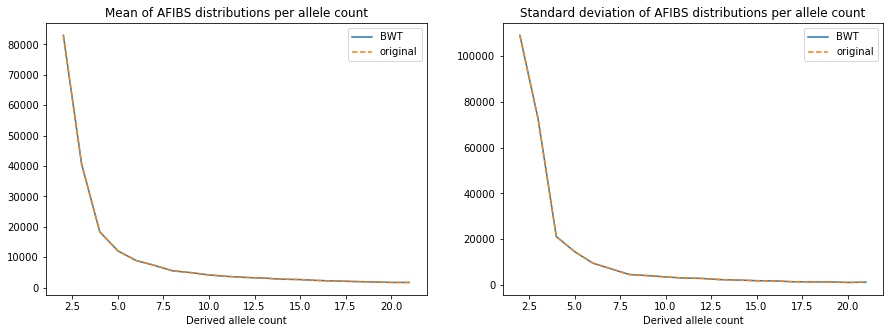

In [7]:
# AFIBS moments (mean, sd)
n_haplo=simu_settings["n_haplo"]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(2, n_haplo),res_afibs_bwt[::2], label='BWT')
plt.plot(np.arange(2, n_haplo),res_afibs[::2], label='original', linestyle='--')
plt.xlabel('Derived allele count')
plt.title('Mean of AFIBS distributions per allele count')
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.arange(2, n_haplo), res_afibs_bwt[1::2], label='BWT')
plt.plot(np.arange(2, n_haplo), res_afibs[1::2], label='original', linestyle='--')
plt.xlabel('Derived allele count')
plt.title('Standard deviation of AFIBS distributions per allele count')
plt.legend()


In [8]:
%timeit ss.distrib_afibs(hap_list, pos_list, count_list, durbin_bwt=False)

1 loop, best of 3: 1.52 s per loop


In [9]:
%timeit ss.distrib_afibs(hap_list, pos_list, count_list, durbin_bwt=True)

1 loop, best of 3: 2.67 s per loop


->   
in the current implementation bwt afibs is slower than the originxal afibs version  
however it does not fail when the number of haplotypes is high  (for example n=80)

## Look at the full AFIBS distribution of one replicate

In [10]:
rep = 0 # replicate index
hap,pos,count = hap_list[rep], pos_list[rep], count_list[rep]

In [11]:
afibs = ss.afibs_durbin_compact(hap,pos,count)

/home/fjay/anaconda3/envs/demoseq/lib/python2.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/fjay/anaconda3/envs/demoseq/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


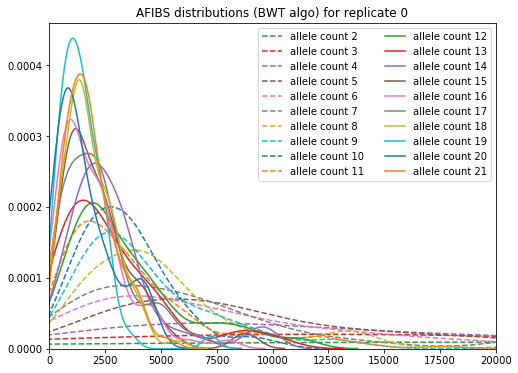

In [12]:
# encounter a warning for the two first items that are empty (AFIBS is not defined for 0 and 1 allele count)
plt.figure(figsize=(8,6))
for i,score in enumerate(afibs):
    ls='--' if i<=len(afibs)/2 else '-'
    sns.distplot(score, hist=False, label='allele count {}'.format(i),
                kde_kws={"linestyle": ls}) 
    
plt.xlim(0,20000)
plt.title('AFIBS distributions (BWT algo) for replicate {}'.format(rep))
plt.legend(ncol=2)


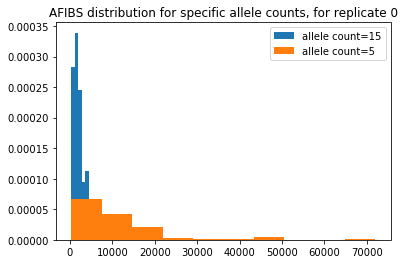

In [13]:
for c in [15,5]:
    plt.hist(afibs[c],label='allele count={}'.format(c),density=True)
plt.title('AFIBS distribution for specific allele counts, for replicate {}'.format(0))
plt.legend()


In [14]:
# convert into a dictionnary if needed
afibs_dict = dict(zip(np.arange(len(afibs)),afibs))